# Restricted Boltzmann Machine - MNIST

## Imports

In [1]:
import sys, datetime

# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

!mkdir FIG 
!mkdir FIG/FRAME
!mkdir WEIGHTS 
!mkdir DATA

mkdir: cannot create directory ‘FIG’: File exists
mkdir: cannot create directory ‘FIG/FRAME’: File exists
mkdir: cannot create directory ‘WEIGHTS’: File exists
mkdir: cannot create directory ‘DATA’: File exists


## Load data

In [2]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(X_original.shape)

/home/jonny/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)


## Parameters

In [3]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3
# use (+1,-1) if SPINS, otherwise use bits (1,0)
SPINS=False
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False

dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

('1', '4', '7')
dataset with 21994 points, each with 784 bits

first 10 MNIST data points


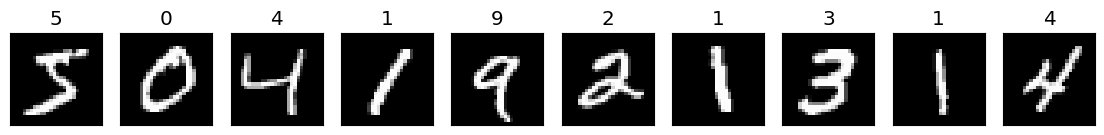

first 10 MNIST-3 data points


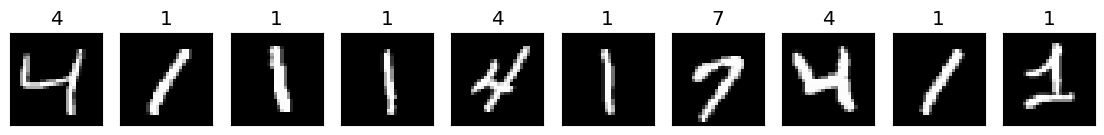

first 10 MNIST-3 data points, binarized


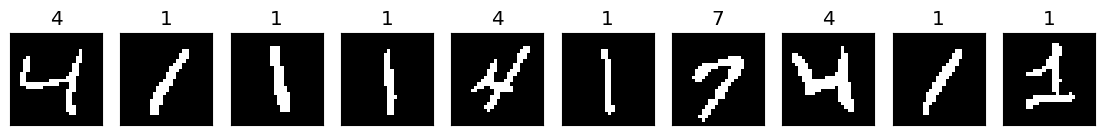

each of Nd=21994 data has D=784 bits


In [4]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "gray"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()
            
def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")

list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[1:8:Ndigit]
print(list_digits)
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]

data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')

## Plotting data stats

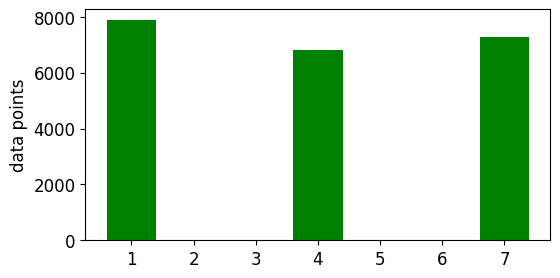

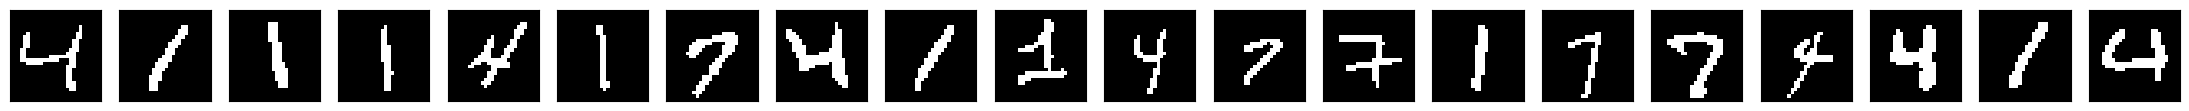

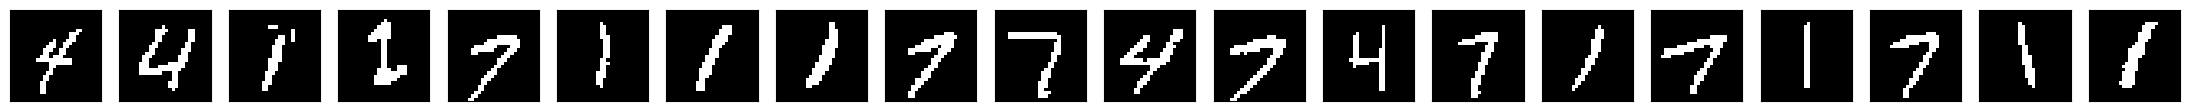

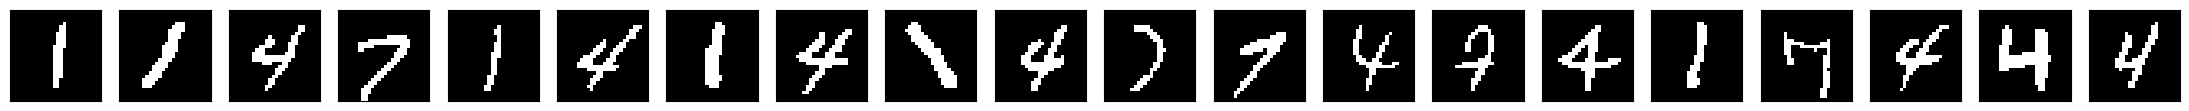

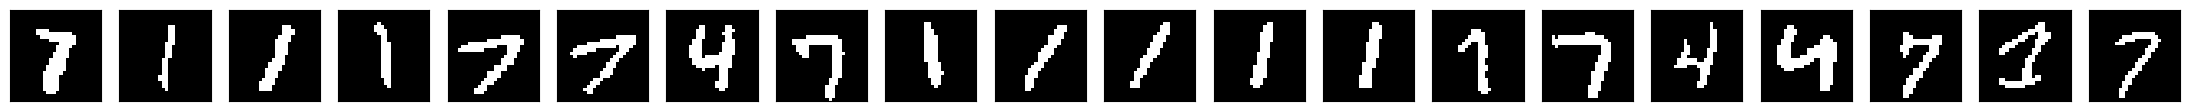

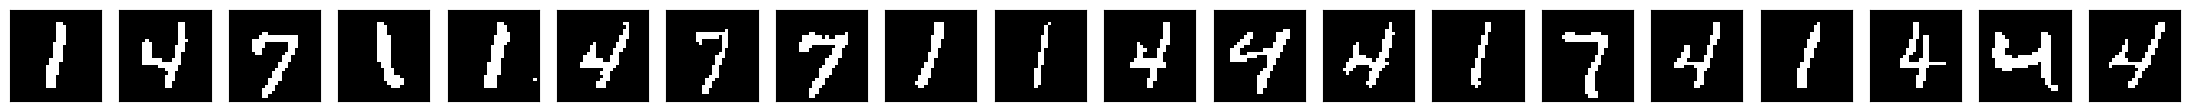

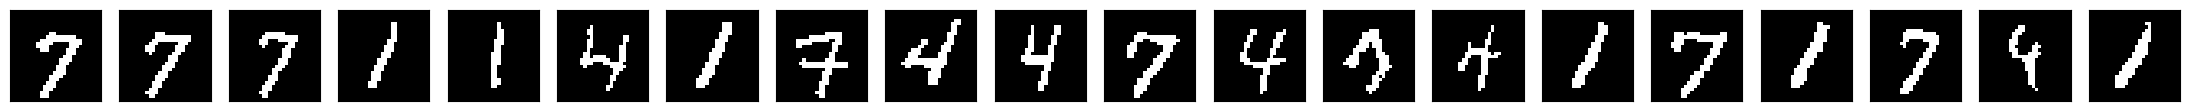

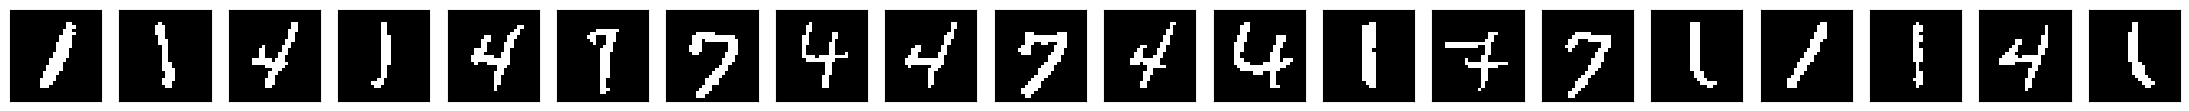

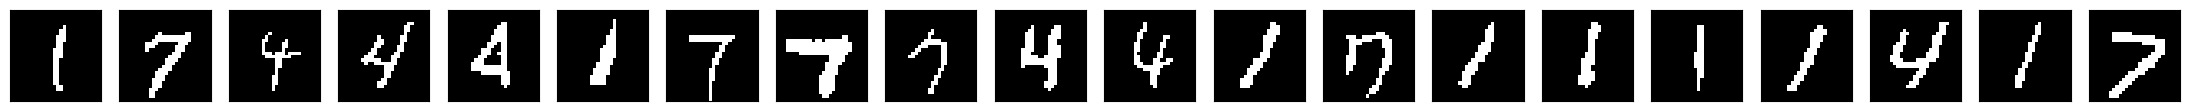

In [5]:
fig, (ax) = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=[0.5,1.5,3.5,4.5,6.5,7.5],density=False,rwidth=0.8,color="g")
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    H = np.clip(np.dot(v_in, wei) + bias, a_min=-300, a_max=300)
    # "activation"
    a = exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]: i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return v_out,p,a
    else: return v_out

## Plot weights

In [7]:
def plot_weights_bias(wE, bE, epoch, L, 
                      side=0,cols=0,thr=0,s=1.5, 
                      title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


## Weights initialization 

In [8]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

## Gradient descent method

In [9]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[1]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

epsilon= 0.0001
D=784	sample size
L=3	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.001	regularization


## Log-likelihood

In [12]:
import itertools as it
from scipy.special import logsumexp

def log_like(x,a,b,w,Q,D): # calculates the log-likelyhood of each sample (x,z)
    # Q= L 
    def hidden_states(Q):  # this is the function to generate z, Q here is the number of hidden units L=3
        conf = it.product((0,1), repeat=Q)
        all_conf=list(conf)
        return all_conf
    
    
    all_conf=hidden_states(Q)
    loglike= 0
    q_values=[]
    Z_z=[]
    G=[]
    E=[]
    
    #for z in all_conf:
    
    for z in all_conf:
        z = np.array(z)  
        g = np.prod(np.exp(np.dot(b,z))) ## sum and product over mu, basically each component
        G.append(g)
        H_z = a+ np.dot(w,z)
        #E.append((-np.dot(a,x)-np.dot(b,z)-np.dot(np.dot(w,z),x) ))
        E.append(-np.dot(H_z,x)-np.dot(b,z) )
        q_values.append(np.mean(1 + np.exp(H_z)))
    q=np.mean(q_values)
    E=np.array(E)
    #E= np.clip(E,-700,700)
    for i,g in enumerate(G):
        Z_z.append(G[i] * np.prod(1 + np.exp(H_z[i])/q))

    term1= logsumexp(-E)
    term2 =D*np.log(q)+np.log(np.sum(Z_z))
    #print("E", E)
    #print(term1,term2)
    return (term1-term2)





In [24]:
import itertools as it
from scipy.special import logsumexp

def log_like_new(X, a, b, w, Q, D):  
    def hidden_states(Q):  # function to generate z, Q here is the number of hidden units (initially L=3)
        conf = it.product((0, 1), repeat=Q)
        all_conf = list(conf)
        return all_conf

    all_conf = hidden_states(Q)
    loglike_list = []  

    # for each sample in the dataset X
    for x in X:  
        x = np.array(x)  
        loglike = 0
        
        q_values = []
        Z_z = []
        G = []
        E = []

        # for each hidden state z
        for z in all_conf:
            z = np.array(z)
            g = np.prod(np.exp(np.dot(b, z)))  # G(z) = prod(exp(b_mu * z_mu))
            G.append(g)
            H_z = a + np.dot(w, z)  # H_i(z) = a_i + sum(w_ij * z_j)
            E.append(-np.dot(H_z, x) - np.dot(b, z))  # E(x, z) = - sum(H_i(z) * x_i) - sum(b_mu * z_mu)
            q_values.append(np.mean(1 + np.exp(H_z)))  # q = mean(1 + exp(H_i(z)))

        q = np.mean(q_values)  
        E = np.array(E)  

        # computation of function Z(z) with the scaling factor q
        for i, g in enumerate(G):
            Z_z.append(G[i] * np.prod(1 + np.exp(H_z[i]) / q))

        term1 = logsumexp(-E)
        term2 = D * np.log(q) + np.log(np.sum(Z_z))

        loglike = term1 - term2
       
        loglike_list.append(loglike)
    print('term 1:',term1, 'term 2:',term2)
    return np.mean(loglike_list)

# RBM train


Nepoch=150
Nmini=20


<Figure size 640x480 with 0 Axes>

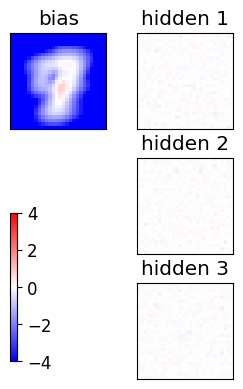

Starting the training
[16053 16112 19222 12024  4937  4793 13844  6809  7045  4699]
[17378 13425  1328  4770 18773  6133 10103  6206 15888  2118]
[18708   199 13590   739 14683 15794 16145  3148  7205 12598]
[15981 18440  2421  3592 19372  6763  6214  8299 11460 20074]
epoch 1 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -61.738317363746745 term 2: 120.25158536900067
Log-likelihood: -178.72648567346914
epoch 2 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -50.68832568140925 term 2: 132.21666452644214
Log-likelihood: -178.7827373851477
epoch 3 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -53.8689641697878 term 2: 133.20769749959865
Log-likelihood: -179.2305390060198
epoch 4 / 150  Nt: 2  N: 10  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -51.23120711250153 term 2: 138.85542789307186
Log-likelihood: -178.49221444094678
epoch 5 / 150  Nt: 2  N: 10  L: 3  r

<Figure size 640x480 with 0 Axes>

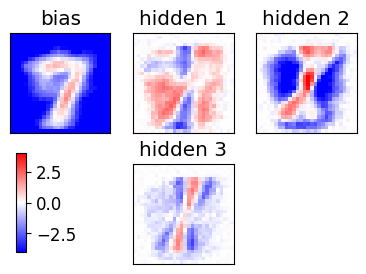

epoch 21 / 150  Nt: 2  N: 18  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -26.307707877916854 term 2: 281.6098371646753
Log-likelihood: -287.99213223575794
epoch 22 / 150  Nt: 2  N: 19  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -23.295806916074085 term 2: 266.77294316108225
Log-likelihood: -274.457610808053
epoch 23 / 150  Nt: 2  N: 20  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -27.983314714536387 term 2: 292.0003753606149
Log-likelihood: -298.9266332435331
epoch 24 / 150  Nt: 2  N: 21  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -31.97237225794967 term 2: 338.02951030195163
Log-likelihood: -342.7688904850102
epoch 25 / 150  Nt: 2  N: 22  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -22.770175833261845 term 2: 342.6935537922936
Log-likelihood: -350.60109653884484
epoch 26 / 150  Nt: 2  N: 23  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -29.93686315923035 term 2: 305.2845

<Figure size 640x480 with 0 Axes>

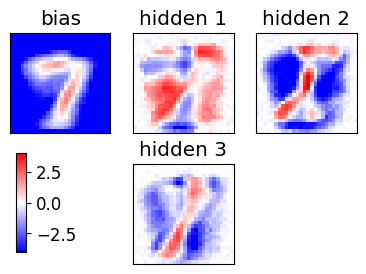

epoch 41 / 150  Nt: 2  N: 45  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -23.16442397695389 term 2: 348.3979300126176
Log-likelihood: -348.22401777815946
epoch 42 / 150  Nt: 2  N: 47  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -11.881755390892286 term 2: 339.92920205981
Log-likelihood: -338.30050683009955
epoch 43 / 150  Nt: 2  N: 48  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -10.15827845966672 term 2: 337.70341411140987
Log-likelihood: -338.7914655951615
epoch 44 / 150  Nt: 2  N: 50  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -7.860603880878238 term 2: 310.3659034878233
Log-likelihood: -311.49549070319347
epoch 45 / 150  Nt: 2  N: 52  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 3.393055133366241 term 2: 328.49646213007685
Log-likelihood: -325.94367776739534
epoch 46 / 150  Nt: 2  N: 54  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -2.451051483674611 term 2: 395.8732972

<Figure size 640x480 with 0 Axes>

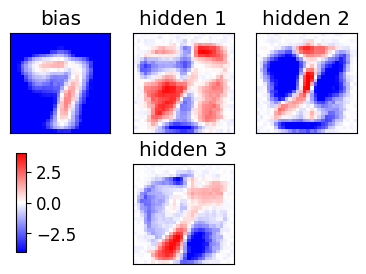

epoch 61 / 150  Nt: 2  N: 89  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 4.019967252696352 term 2: 439.0093318650857
Log-likelihood: -436.48021479800525
epoch 62 / 150  Nt: 2  N: 92  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -3.9991451943500733 term 2: 430.5543226484202
Log-likelihood: -431.04618111652167
epoch 63 / 150  Nt: 2  N: 94  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 6.826231524349174 term 2: 400.0155289556438
Log-likelihood: -397.8518940974815
epoch 64 / 150  Nt: 2  N: 97  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 7.320507318133799 term 2: 399.795050383208
Log-likelihood: -398.1662828610783
epoch 65 / 150  Nt: 2  N: 100  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 2.001452646071712 term 2: 419.45143099128154
Log-likelihood: -418.5315672548106
epoch 66 / 150  Nt: 2  N: 103  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 7.658440037870393 term 2: 354.71964449381

<Figure size 640x480 with 0 Axes>

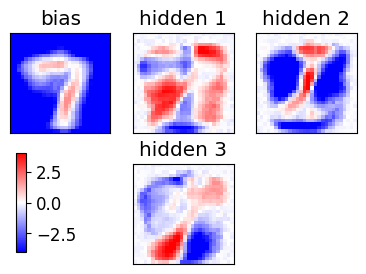

epoch 81 / 150  Nt: 2  N: 151  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -2.5227091071224454 term 2: 437.56193782662854
Log-likelihood: -436.3429181314661
epoch 82 / 150  Nt: 2  N: 154  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 6.744772029561645 term 2: 386.61909943729256
Log-likelihood: -384.2102170680809
epoch 83 / 150  Nt: 2  N: 158  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 2.7888047324085243 term 2: 414.09191664179923
Log-likelihood: -413.6731397436973
epoch 84 / 150  Nt: 2  N: 162  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -2.6515464391721286 term 2: 407.883594922029
Log-likelihood: -407.5845184737195
epoch 85 / 150  Nt: 2  N: 165  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 0.5955560402886839 term 2: 395.54283761682836
Log-likelihood: -394.3156299792429
epoch 86 / 150  Nt: 2  N: 169  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 0.09586683860562872 term 2: 402.

<Figure size 640x480 with 0 Axes>

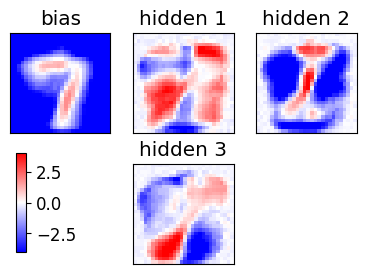

epoch 101 / 150  Nt: 2  N: 230  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -0.41705684366243645 term 2: 364.79797468146114
Log-likelihood: -365.68346919592165
epoch 102 / 150  Nt: 2  N: 235  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 0.28590771831223183 term 2: 366.62084618297195
Log-likelihood: -366.6027172676009
epoch 103 / 150  Nt: 2  N: 239  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -3.8821469760148277 term 2: 372.3193483490597
Log-likelihood: -373.0480599965982
epoch 104 / 150  Nt: 2  N: 244  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -6.597268275409837 term 2: 393.65583787032256
Log-likelihood: -393.9399539994204
epoch 105 / 150  Nt: 2  N: 248  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -5.658084311283458 term 2: 386.52344711495994
Log-likelihood: -387.4369890315361
epoch 106 / 150  Nt: 2  N: 253  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 0.5217263664086955 te

<Figure size 640x480 with 0 Axes>

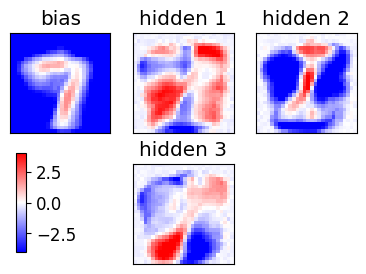

epoch 121 / 150  Nt: 2  N: 327  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -5.369527057290373 term 2: 374.90667414234355
Log-likelihood: -376.334987936934
epoch 122 / 150  Nt: 2  N: 333  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -4.607613693937644 term 2: 385.3866426252927
Log-likelihood: -387.3496963342047
epoch 123 / 150  Nt: 2  N: 338  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -4.484620255908101 term 2: 350.81458962447556
Log-likelihood: -352.561543190276
epoch 124 / 150  Nt: 2  N: 343  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: 0.6257207225551942 term 2: 370.2564959631696
Log-likelihood: -370.3331759344034
epoch 125 / 150  Nt: 2  N: 349  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -3.7626918226374966 term 2: 375.8627919873812
Log-likelihood: -377.9556381941554
epoch 126 / 150  Nt: 2  N: 354  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -1.7602895177658777 term 2: 3

<Figure size 640x480 with 0 Axes>

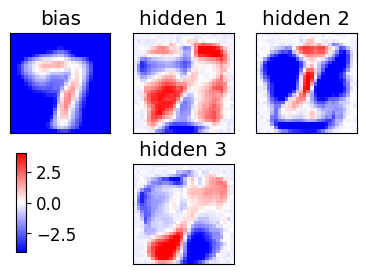

epoch 141 / 150  Nt: 2  N: 442  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -3.210883769233401 term 2: 399.7829017679279
Log-likelihood: -399.2514286374312
epoch 142 / 150  Nt: 2  N: 448  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -3.319959370954627 term 2: 385.5383820447633
Log-likelihood: -386.2636714720003
epoch 143 / 150  Nt: 2  N: 455  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -3.518504605936069 term 2: 393.2568220007692
Log-likelihood: -394.7804704186373
epoch 144 / 150  Nt: 2  N: 461  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -6.9587056982865585 term 2: 367.66629838909597
Log-likelihood: -369.1235374885435
epoch 145 / 150  Nt: 2  N: 467  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -5.231607601789329 term 2: 395.8452504278572
Log-likelihood: -398.2159140137472
epoch 146 / 150  Nt: 2  N: 474  L: 3  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
term 1: -8.578390308053114 term 2: 3

<Figure size 640x480 with 0 Axes>

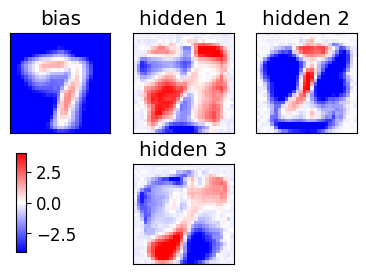

END of learning phase


In [27]:
# random seed for reproducibility
np.random.seed(12345)

# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(D,L)
#a = sigma * np.random.randn(D)
# using Hinton initialization of visible biases
a = Hinton_bias_init(data)
# hidden biases initialized to zero
b = np.zeros(L)
#print("w=",w);print("a=",a);print("b=",b)
loglike=0
# nr of epochs
Nepoch=150
# minibatches per epoch
Nmini=20
# minibatch size at initial epoch and final one
N_ini,N_fin=10,500
print(f"Nepoch={Nepoch}\nNmini={Nmini}")
# number of CD steps
Nt=2

# recording history of weights ("E" means epoch)
wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L))
wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
miniE = np.zeros(Nepoch+1)
pzE=np.zeros((Nepoch+1,Nz))
if GRAD=="RMSprop": 
    gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)

indices=np.arange(Nd).astype("int")
plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)

# for the plot with panels
Ncols=min(8,max(2,L//2))

if POTTS: print("Starting the training, POTTS=True")
else: print("Starting the training")

# Note: here an epoch does not analyze the whole dataset
for epoch in range(1,1+Nepoch):
    # q maps epochs to interval [0,1]
    q = (epoch-1.)/(Nepoch-1.) 
    # N, size of the mini batch
    # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
    N = int(N_ini + (N_fin-N_ini)*(q**2))
    #  l_rate interpolates between initial and final value
    l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q

    for mini in range(Nmini):
        # initializitation for averages in minibatch
        # visible variables "v" --> "x"
        #  hidden variables "h" --> "z"
        x_data, x_model = np.zeros(D),np.zeros(D)
        z_data, z_model = np.zeros(L),np.zeros(L)
        xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
        pz = np.zeros(L)
        
        # Minibatch of size N: points randomply picked (without repetition) from data
        selected = np.random.choice(indices,N,replace=False)
        if epoch==1 and mini<=3: print(selected)
        
        for k in range(N):
            ###################################
            x0 = data[selected[k]]
            # positive CD phase: generating z from x[k]
            z = CD_step(x0,w,b,POTTS=POTTS)
            x_data  += x0
            z_data  += z
            xz_data += np.outer(x0,z)
            # fantasy
            zf=np.copy(z)
            # Contrastive divergence with Nt steps
            for t in range(Nt):
                # negative CD pzase: generating fantasy xf from fantasy zf
                xf = CD_step(zf,w.T,a)
                # positive CD phase: generating fantasy zf from fantasy xf 
                zf = CD_step(xf,w,b,POTTS=POTTS)
            x_model += xf
            z_model += zf
            xz_model+= np.outer(xf,zf)
           # loglike += log_like(x_data,a,b,w,L,D)/N 
        
            # recording probability of encoding in z-space, if POTTS
            if POTTS: pz[zf]+=1
            ###################################
        
        # gradient of the likelihood: follow it along its positive direction
        gw_d,gw_m = xz_data/N, xz_model/N
        ga_d,ga_m = x_data/N, x_model/N
        gb_d,gb_m = z_data/N, z_model/N
        gw=np.copy(gw_d - gw_m)
        ga=np.copy(ga_d - ga_m)
        gb=np.copy(gb_d - gb_m)

        # gradient ascent step
        if GRAD=="RMSprop":
            # RMSprop gradient ascent
            gw2 = beta*gw2+(1-beta)*np.square(gw)
            ga2 = beta*ga2+(1-beta)*np.square(ga)
            gb2 = beta*gb2+(1-beta)*np.square(gb)
            w += l_rate*gw/sqrt(epsilon+gw2)
            a += l_rate*ga/sqrt(epsilon+ga2)
            b += l_rate*gb/sqrt(epsilon+gb2)
        else: 
            # defaulting to the vanilla stochastic gradient ascent (SGD)
            w += l_rate*gw
            a += l_rate*ga
            b += l_rate*gb
        # regularization (LASSO)
        if gamma>0.:
            w -= (gamma*l_rate)*sign(w)
            a -= (gamma*l_rate)*sign(a)
            b -= (gamma*l_rate)*sign(b)

    wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
    aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
    bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
    miniE[epoch]=N
    if POTTS: pzE[epoch] = pz/np.sum(pz)
    print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
          " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)
    print('Log-likelihood:',log_like_new(data,a,b,w,L,D) )
    if Nepoch<=100 or epoch%20==0 or epoch==Nepoch:
        plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)
            
    str_time_completion = datetime.datetime.now().strftime("_%Y%m%d_%H%M")

print("END of learning phase")

## Test generative power of the trained RBM

In [ ]:
ee=-1
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=1.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf 
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF)

## Plot of the gradient amplitude

In [ ]:
def make_fname(strin):
    fname="FIG/RBM_"+strin+"_MNIST"+str(Ndigit)+"_E"+str(NE)+"_N"+str(N_ini)+"-"+str(N_fin)
    fname=fname+"_"+GRAD+"-"+str(l_rate_ini)+"-"+str(l_rate_fin)+"_CD-"+str(Nt)+"_L"+str(L)
    if gamma>0:  fname=fname+"_reg"+str(gamma)
    return fname+".png"

NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\sim 1 / \sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)

## Save weights over epochs on file

In [ ]:
def make_weights_fname(label,dname="WEIGHTS"):
    fname=dname+"/"+label+"_"+str_simul+"_MNIST"+str(Ndigit)+"_L"+str(L)
    fname=fname+"_"+GRAD+"-"+"{:.2f}".format(l_rate_ini)+"-"+"{:.2f}".format(l_rate_fin)+"_Ep"+str(Nepoch)
    if gamma>0:  fname=fname+"_reg"+"{:.3g}".format(gamma)
    if POTTS: fname+="_POTTS"
    if SPINS: fname+="_SPINS"
    fname=fname+str_time_completion
    return fname+".npy"

def save_epochs(qE,label):
    fname=make_weights_fname(label)
    print(fname)
    np.save(fname,qE)

save_epochs(wE,"w")
save_epochs(bE,"b")
save_epochs(aE,"a")

In [ ]:
Nd

In [ ]:
import pandas as pd

df= np.load('WEIGHTS/w_RBM_MNIST3_L3_RMSprop-0.05-0.05_Ep150_reg0.001_20250313_1047.npy')
df_w= df[10,:,:]
df_w= pd.DataFrame(df_w)
df_w.describe()


In [ ]:
df= np.load('WEIGHTS/a_RBM_MNIST3_L3_RMSprop-0.05-0.05_Ep150_reg0.001_20250313_1047.npy')
df_a= pd.DataFrame(df)
df_a.describe()


In [ ]:
df= np.load('WEIGHTS/b_RBM_MNIST3_L3_RMSprop-0.05-0.05_Ep150_reg0.001_20250313_1047.npy')
df_b= pd.DataFrame(df)
df_b.describe()